Train/Val/Test split

LSTM Autoencoder

Randomized sentetik anomaly injection

Sliding windows

Reconstruction error hesaplama

Pointwise error atama

Thresholding + ROC/F1/AP skorları

Görselleştirme

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt

In [3]:

# ------------------ 0️⃣ Device ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [4]:
# ------------------ 1️⃣ Load Data ------------------
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df   = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")

In [5]:
# ------------------ 2️⃣ Normalize ------------------
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df["OT"].values.reshape(-1, 1)).flatten()
val_scaled   = scaler.transform(val_df["OT"].values.reshape(-1, 1)).flatten()

In [6]:

# ------------------ 3️⃣ Sliding window ------------------
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data) - window_size + 1)])


window_size = 96
train_windows = create_windows(train_scaled, window_size)
val_windows   = create_windows(val_scaled, window_size)

train_tensor = torch.tensor(train_windows, dtype=torch.float32).unsqueeze(-1)
val_tensor   = torch.tensor(val_windows, dtype=torch.float32).unsqueeze(-1)

batch_size = 64
train_loader_ae = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
val_loader_ae   = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=batch_size, shuffle=False)


In [7]:
# ------------------ 4️⃣ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.enc_fc  = nn.Linear(hidden_dim, latent_dim)
        self.dec_fc  = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.output  = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        last_h = h_n[-1]
        latent = self.enc_fc(last_h)
        T = x.size(1)
        dec_input = self.dec_fc(latent).unsqueeze(1).repeat(1, T, 1)
        dec_input = self.layernorm(dec_input)
        dec_input = self.dropout(dec_input)
        dec_out, _ = self.decoder(dec_input)
        out = self.output(dec_out)
        return out

input_dim  = 1
hidden_dim = 64
latent_dim = 16
num_layers = 2

model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = nn.MSELoss()

In [8]:
# ------------------ 5️⃣ Training Loop ------------------
num_epochs = 100
patience   = 12
best_val   = np.inf
pat_cnt    = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, _ in train_loader_ae:
        xb = xb.to(device)
        noisy = xb + 0.02 * torch.randn_like(xb).to(device)
        optimizer.zero_grad()
        out = model(noisy)
        loss = loss_fn(out, xb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_ae.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, _ in val_loader_ae:
            xb = xb.to(device)
            out = model(xb)
            val_loss += loss_fn(out, xb).item() * xb.size(0)
    val_loss /= len(val_loader_ae.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.6f} - Val: {val_loss:.6f}")

    if val_loss < best_val:
        best_val = val_loss
        pat_cnt = 0
        best_state = model.state_dict()
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_state)


Epoch 1/100 - Train: 0.229446 - Val: 0.072259
Epoch 2/100 - Train: 0.105795 - Val: 0.058117
Epoch 3/100 - Train: 0.098333 - Val: 0.056955
Epoch 4/100 - Train: 0.091756 - Val: 0.068957
Epoch 5/100 - Train: 0.087645 - Val: 0.065079
Epoch 6/100 - Train: 0.085778 - Val: 0.052852
Epoch 7/100 - Train: 0.085610 - Val: 0.053794
Epoch 8/100 - Train: 0.083787 - Val: 0.061634
Epoch 9/100 - Train: 0.085667 - Val: 0.051773
Epoch 10/100 - Train: 0.084004 - Val: 0.053134
Epoch 11/100 - Train: 0.083600 - Val: 0.051114
Epoch 12/100 - Train: 0.085984 - Val: 0.051211
Epoch 13/100 - Train: 0.082159 - Val: 0.050727
Epoch 14/100 - Train: 0.081162 - Val: 0.050941
Epoch 15/100 - Train: 0.081951 - Val: 0.050731
Epoch 16/100 - Train: 0.082252 - Val: 0.052188
Epoch 17/100 - Train: 0.081013 - Val: 0.050166
Epoch 18/100 - Train: 0.082688 - Val: 0.052321
Epoch 19/100 - Train: 0.072645 - Val: 0.038892
Epoch 20/100 - Train: 0.063526 - Val: 0.034713
Epoch 21/100 - Train: 0.061281 - Val: 0.030658
Epoch 22/100 - Train: 

<All keys matched successfully>

In [9]:
# ------------------ 6️⃣ Random Synthetic Anomalies ------------------
def generate_synthetic_anomalies(series, num_anomalies=10, window_lengths=(10,50), amplitude_range=(2.0,6.0)):
    series = series.copy()
    labels = np.zeros_like(series)
    N = len(series)
    rng = np.random.default_rng()
    for _ in range(num_anomalies):
        anomaly_type = rng.choice(['point', 'level_shift', 'noise_burst', 'collective'])
        start_idx = rng.integers(0, N-1)
        if anomaly_type == 'point':
            amp = rng.uniform(*amplitude_range)
            series[start_idx] += amp
            labels[start_idx] = 1
        elif anomaly_type == 'level_shift':
            length = rng.integers(*window_lengths)
            end = min(start_idx+length, N)
            offset = rng.uniform(*amplitude_range)
            series[start_idx:end] += offset
            labels[start_idx:end] = 1
        elif anomaly_type == 'noise_burst':
            length = rng.integers(*window_lengths)
            end = min(start_idx+length, N)
            series[start_idx:end] += rng.normal(0, np.std(series)*2, end-start_idx)
            labels[start_idx:end] = 1
        elif anomaly_type == 'collective':
            length = rng.integers(*window_lengths)
            end = min(start_idx+length, N)
            pattern = np.sin(np.linspace(0, np.pi, end-start_idx)) * rng.uniform(*amplitude_range)
            series[start_idx:end] = pattern
            labels[start_idx:end] = 1
    return series, labels

# Base test series (train_scaled üzerinden örnek)
test_series = train_scaled.copy()
test_series, anomaly_labels = generate_synthetic_anomalies(test_series,
                                                           num_anomalies=12,
                                                           window_lengths=(20,60),
                                                           amplitude_range=(2.0,6.0))


In [10]:
# ------------------ 7️⃣ Test loader ------------------
test_scaled = scaler.transform(test_series.reshape(-1,1)).flatten()
test_windows = create_windows(test_scaled, window_size)
test_tensor = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)
test_loader_ae = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=64, shuffle=False)
test_labels = np.array([1 if np.any(anomaly_labels[i:i+window_size]) else 0 for i in range(len(test_windows))])


In [11]:
# ------------------ 8️⃣ Reconstruction & Error ------------------
model.eval()
recons = []
with torch.no_grad():
    for xb, _ in test_loader_ae:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        recons.append(out)
recons = np.vstack(recons).squeeze(-1)

window_mse = np.mean((recons - test_windows)**2, axis=1)

N = len(test_series)
pointwise_err = np.zeros(N)
counts = np.zeros(N)
half = window_size//2
for i, w_err in enumerate(window_mse):
    center_idx = i + half
    if center_idx < N:
        pointwise_err[center_idx] += w_err
        counts[center_idx] += 1
nonzero = counts>0
pointwise_err[nonzero] /= counts[nonzero]

valid_err = pointwise_err[half:]
valid_labels = anomaly_labels[half:]

Best threshold: 204.115411 with F1-score: 0.4117
ROC AUC: 0.8918
Precision: 0.5640, Recall: 0.3241, F1: 0.4117, AP: 0.3042


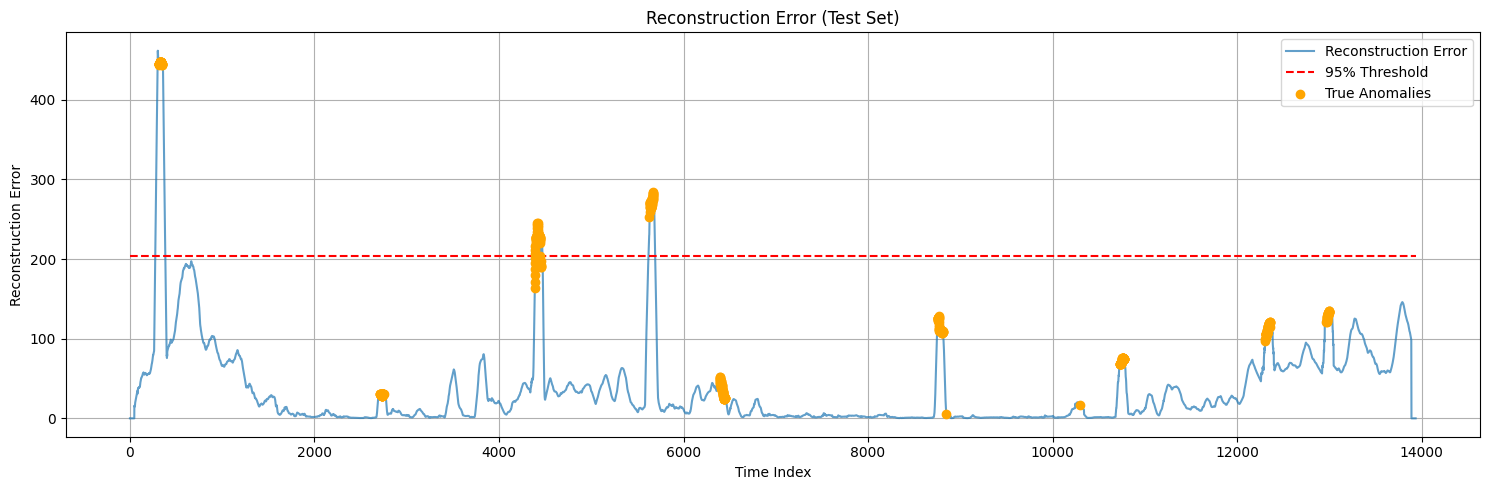

In [16]:
# ------------------ 9️⃣ Threshold Optimization & Metrics ------------------

# --- Threshold Optimization ---
# Try thresholds between 0 and max error
thresholds = np.linspace(valid_err.min(), valid_err.max(), 200)
f1_scores = []

for thr in thresholds:
    preds = (valid_err >= thr).astype(int)
    f1 = f1_score(valid_labels, preds)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.6f} with F1-score: {best_f1:.4f}")

preds = (valid_err >= best_threshold).astype(int)

roc_auc = roc_auc_score(valid_labels, valid_err)
precision = precision_score(valid_labels, preds)
recall    = recall_score(valid_labels, preds)
f1        = f1_score(valid_labels, preds)
ap_score  = average_precision_score(valid_labels, valid_err)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap_score:.4f}")

# ------------------ 🔟 Plot ------------------
plt.figure(figsize=(15,5))
plt.plot(pointwise_err, label='Reconstruction Error', alpha=0.7)
plt.hlines(best_threshold, 0, len(pointwise_err), colors='r', linestyles='dashed', label='95% Threshold')
plt.scatter(np.where(anomaly_labels==1), pointwise_err[anomaly_labels==1], color='orange', label='True Anomalies', zorder=5)
plt.title('Reconstruction Error (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion Matrix as string:
[[13344   109]
 [  294   141]]


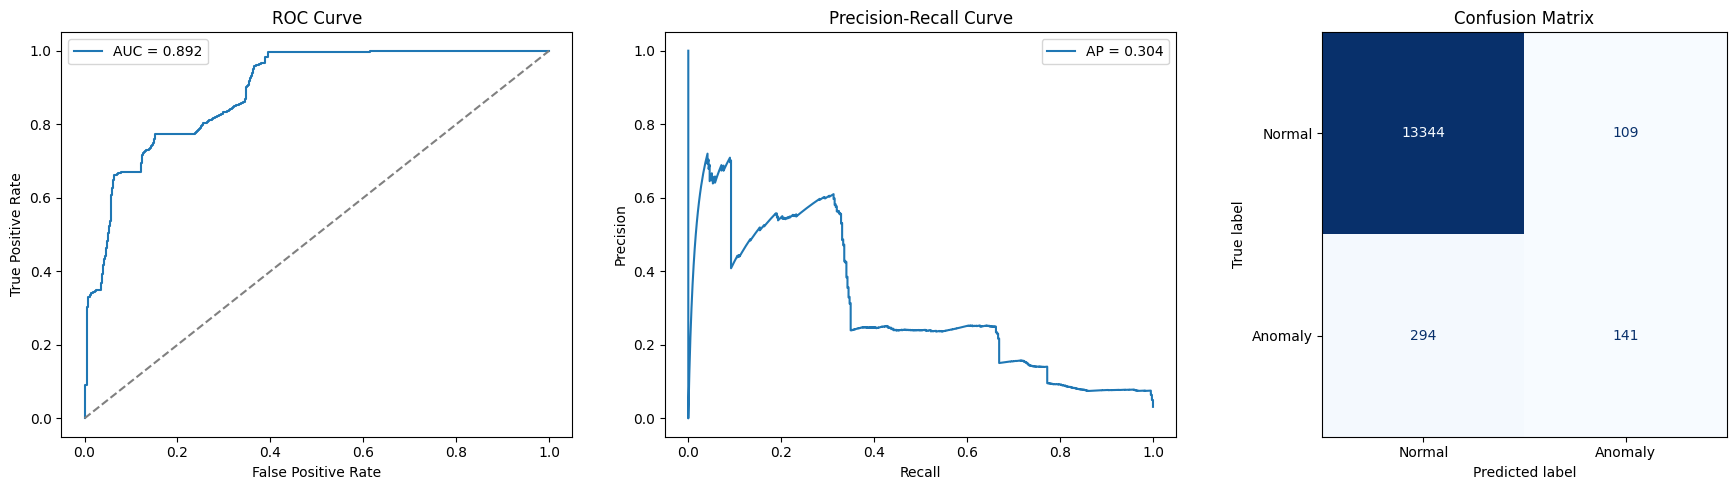

In [18]:
# --------- Plot ROC, Precision-Recall Curves and Confusion Matrix  ---------

from sklearn.metrics import roc_curve, precision_recall_curve,confusion_matrix, ConfusionMatrixDisplay

# Plot ROC and PR curves
fpr, tpr, _ = roc_curve(valid_labels, valid_err)
prec_curve, rec_curve, _ = precision_recall_curve(valid_labels, valid_err)

# Compute confusion matrix
cm = confusion_matrix(valid_labels, preds)

print("Confusion Matrix as string:")
print(str(cm))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

plt.figure(figsize=(18, 5))

# ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(rec_curve, prec_curve, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Confusion Matrix
plt.subplot(1,3,3)
disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [24]:
# print accuracy
accuracy = np.sum(preds == valid_labels) / len(valid_labels)
print(f"Accuracy: {accuracy:.4f}")

print(f"Predicted anomalies (TP+FP) = {np.sum(preds)}")
print(f"True anomalies = {np.sum(valid_labels)}")
print(f"Precision(actual anomalies percentage): {precision:.4f} (True anomalies / Predicted anomalies)")

print(f"Missed anomalies (FN): {np.sum((valid_labels == 1) & (preds == 0))}")
print(f"False alarms (FP): {np.sum((valid_labels == 0) & (preds == 1))}")


Accuracy: 0.9710
Predicted anomalies (TP+FP) = 250
True anomalies = 435.0
Precision(actual anomalies percentage): 0.5640 (True anomalies / Predicted anomalies)
Missed anomalies (FN): 294
False alarms (FP): 109


In [ ]:
# Your model is good at identifying normal points (very few FPs, high TN rate).

# But it misses many anomalies (high FN count), meaning low recall.

# You are conservative in predicting anomalies — you catch fewer but with moderate precision.

# If the goal is to catch as many anomalies as possible, you might need to:

# Lower the threshold (to improve recall, but risk more false alarms).

# Use a more anomaly-sensitive loss function or model.

# Combine reconstruction error with other anomaly features.